## Background

information spreads rapidly through various online platforms. However, not all disseminated **information is factual**, and the **spread of fake news** poses a significant challenge, negatively impacting individuals and society. To address this issue, technologies like **deep learning**, particularly **Long Short-Term Memory (LSTM)**, can be utilized to analyze and classify news based on its authenticity. LSTM is chosen for its superior ability to process text data and identify patterns in sequential data.
This **project aims** to **develop an LSTM-based machine learning model** capable of automatically **detecting and classifying fake news**. The project seeks to **assist individuals and digital platforms** in filtering out false information and enhancing trust in credible news sources.

## Import Library & Data

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_fake = pd.read_csv('/kaggle/input/fake-news-detection/fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
df_real = pd.read_csv('/kaggle/input/fake-news-detection/true.csv')
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
df_fake['label'] = 'Fake'
df_real['label'] = 'Real'
df = pd.concat([df_fake,df_real])
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


## Data Cleaning

In [5]:
print(f'Data rows: {df.shape[0]}, Data columns: {df.shape[1]}')

Data rows: 44898, Data columns: 5


In [6]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [7]:
df.duplicated().sum()

209

In [8]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f'Data rows after cleaning: {df.shape[0]}, Data columns after cleaning: {df.shape[1]}')

Data rows after cleaning: 44689, Data columns after cleaning: 5


## Preprocessing Text

### Case Folding & Cleaning Text

In [9]:
def clean_text(text):
    # Converting all text to lowercase
    text = text.lower()
    
    # Delete link/URL
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    
    # Delete emoji and characters non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Normalize Words
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "i am", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    # Remove punctuation and other symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Delete numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Removing double spaces that may form
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
df['text'] = df['text'].apply(clean_text)

In [10]:
df.sample(5)

,title,text,subject,date,label
11569,UNPRECEDENTED: New York Times To Run 30 Sec Ad...,the new york ti ames is set to launch a televi...,politics,"Feb 26, 2017",Fake
19112,OBAMA’S DOJ SUED Michigan City To Allow MEGA-M...,there is only one way to stop this mosque from...,left-news,"Feb 21, 2017",Fake
22622,ART OF WAR: What’s Behind Russia’s ‘Ides of Ma...,appear weak when you are strong and strong whe...,US_News,"March 18, 2016",Fake
2906,Groups see climate science review as chance to...,washington reuters the trump administration wi...,politicsNews,"July 5, 2017",Real
556,Trump Justice Department Is Going After Anyon...,while science doesn t quite have the technolog...,News,"August 15, 2017",Fake


### Stopwords & Stemming

In [11]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

df['text'] = df['text'].apply(preprocess_text)

In [12]:
df.sample(5)

,title,text,subject,date,label
7376,Trump And Carson Dancing While Being Serenade...,lot strang thing happen cours elect cycl wit m...,News,"March 21, 2016",Fake
16172,BREAKING: D.C. Driver Plows Into Capitol Polic...,happen around block independ ave sw driver arr...,Government News,"Mar 29, 2017",Fake
21269,Germany keen to avoid new 'ice age' in ties be...,washington reuter germani europ want ensur new...,worldnews,"August 29, 2017",Real
3230,Trump says healthcare reform push may need add...,washington reuter presid donald trump tuesday ...,politicsNews,"June 13, 2017",Real
1666,Trump Set Up An Alien Crime Hotline And It We...,recent donald trump becam second major elect l...,News,"April 27, 2017",Fake


## Exploratory Data Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [14]:
words_fake = df[df['label'] == 'Fake']
list_words_fake = words_fake['text']
words_real = df[df['label'] == 'Real']
list_words_real = words_real['text']

### What Happened?

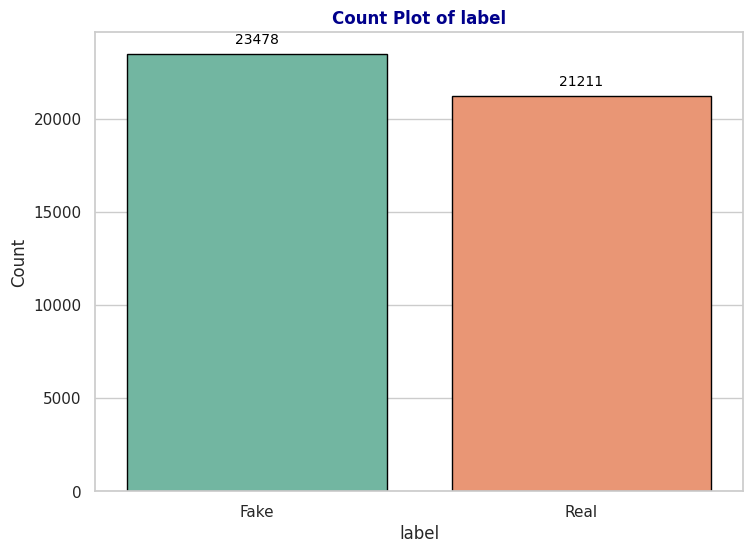

In [15]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x='label', palette="Set2", edgecolor="black")
plt.title(f'Count Plot of label', fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12)
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
plt.tight_layout(pad=2)
plt.show()

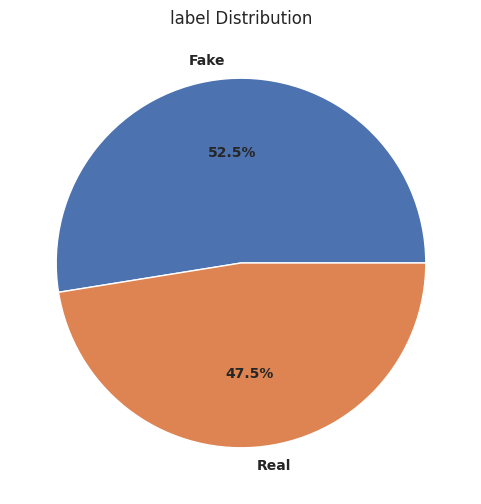

In [16]:
plt.figure(figsize=(6,6))
plt.pie(x =df['label'].value_counts().values , labels=df['label'].value_counts().keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"})
plt.title('label Distribution') 
plt.show()

The dataset contains **23478 instances (52.5%) labeled as "Fake News"** and **21211 instances (47.5%) labeled as "Real News"**.

### What the most type of news is real or fake?

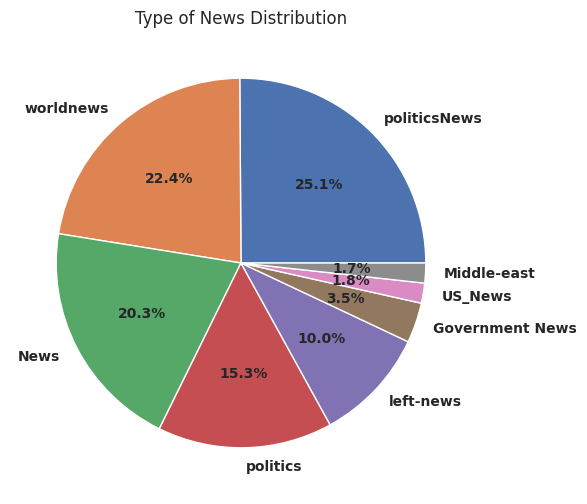

In [17]:
plt.figure(figsize=(6,6))
plt.pie(x =df['subject'].value_counts().values , labels=df['subject'].value_counts().keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"})
plt.title('Type of News Distribution') 
plt.show()

In [18]:
pd.crosstab(df['label'] , df['subject']).T.style.background_gradient(subset=['Fake'],cmap='Reds')\
.background_gradient(subset=['Real'] , cmap='Greens')

label,Fake,Real
subject,,
Government News,1570,0
Middle-east,778,0
News,9050,0
US_News,783,0
left-news,4459,0
politics,6838,0
politicsNews,0,11220
worldnews,0,9991


- The category with the **most fake news** is **News** with **9,050** fake articles, followed by **politics** with **6,838** fake articles.
- The category with the **most real news** is **politicsNews** with **11,220** real articles, followed by **worldnews** with **9,991** real articles.

### What words frequently appear in news?

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


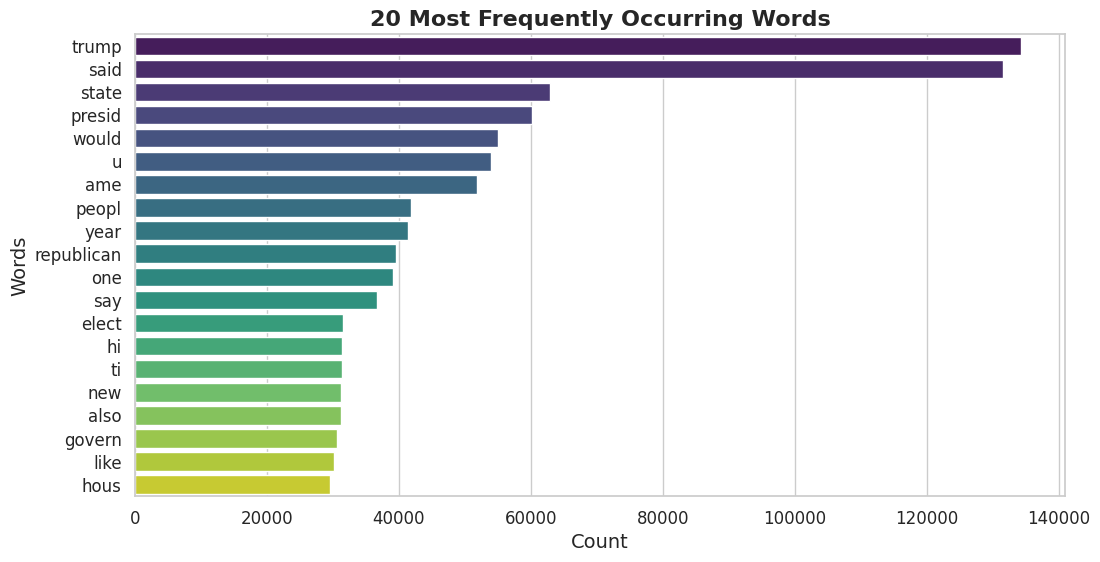

In [19]:
text = " ".join(df["text"])
tokens = text.split()

word_counts = Counter(tokens)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Setup tema seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("20 Most Frequently Occurring Words", fontsize=16, fontweight='bold')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

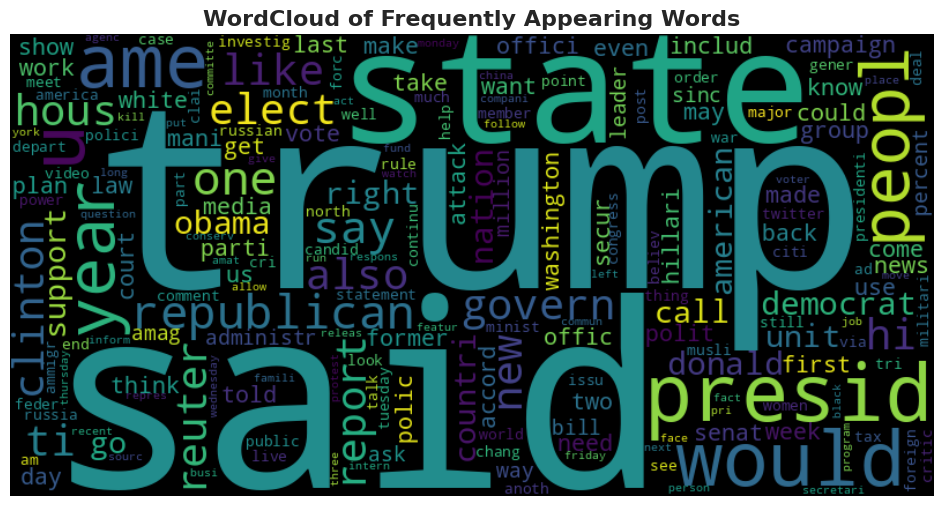

In [20]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='viridis'
).generate_from_frequencies(word_counts)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Frequently Appearing Words", fontsize=16, fontweight='bold')
plt.show()

"trump," "said," "state," "presid" (likely stemming from "president"), and "would."
These words suggest a strong focus on political events and statements, particularly involving the U.S. presidency.

### What words often appear in fake news?

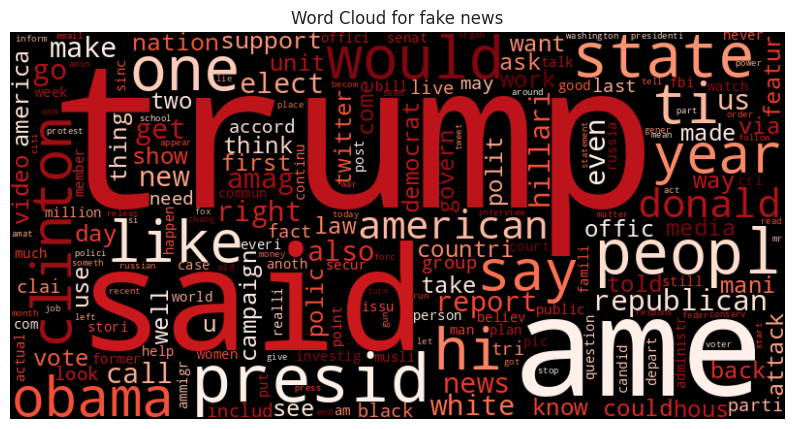

In [21]:
words_fake = ' '.join(list_words_fake)

fake = words_fake.split()
word_counts_fake = Counter(fake)

common_words_fake = word_counts_fake.most_common(10)

wordcloud_fake = WordCloud(
    width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(word_counts_fake)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for fake news")
plt.show()

"trump," "ame" (possibly stemming from "America"), "presid" (likely "president"), "like," "clinton," and "peopl."
These words indicate a significant focus on political figures and events, often involving controversial or polarizing topics, which are common in fake news narratives.

### What words often appear in real news?

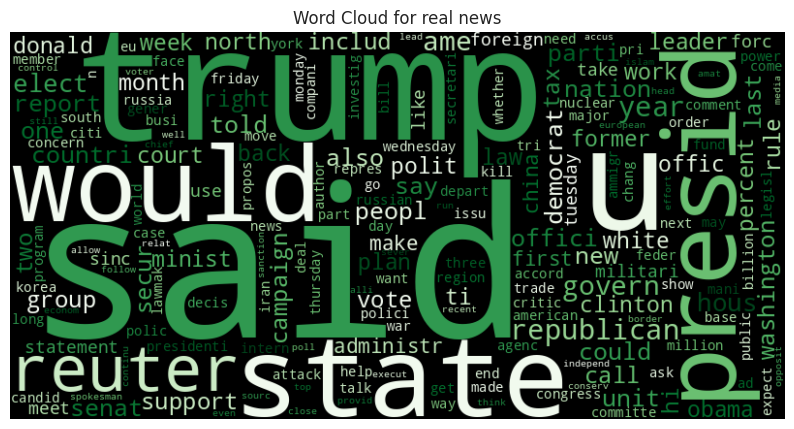

In [22]:
words_real = ' '.join(list_words_real)

real = words_real.split()
word_counts_real = Counter(real)

common_words_real = word_counts_real.most_common(10)


wordcloud_real = WordCloud(
    width=800, height=400, background_color='black', colormap='Greens').generate_from_frequencies(word_counts_real)

# Plotting the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for real news")
plt.show()

"reuter" (likely referring to Reuters, a reputable news agency), "republican," "presid" (likely "president"), "trump," "state," and "said."
These words reflect a focus on official reports, political figures, and statements, which are characteristic of real news articles based on credible sources and factual reporting.

## Feature Extraction

In [23]:
df = df[['text','label']]
df.sample(5)

,text,label
3711,demand allegi head state condit becom citizen ...,Fake
1915,rep maxin water say someth want talk ampeach s...,Fake
19083,,Fake
2177,washington reuter top tax law writer u hous re...,Real
10768,washington reuter presid barack obama cannot s...,Real


In [24]:
texts = df['text'].values
labels = df['label'].values

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
for i, atribut in enumerate(label_encoder.classes_):
    print(f'The attribute of "{atribut}" is converted to: {i}')

The attribute of "Fake" is converted to: 0
The attribute of "Real" is converted to: 1


In [26]:
vocab_size = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=vocab_size) 
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(encoded_labels)

In [27]:
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer saved.")

Tokenizer saved.


## Data Splitting

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (35751, 100)
X_test Shape: (8938, 100)
y_train Shape: (35751,)
y_test Shape: (8938,)


## Model Development

In [84]:
from tensorflow.keras.regularizers import l2
model = models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length),
    layers.LSTM(100,kernel_regularizer=l2(0.01)),
    # layers.Dropout(0.5),  
    # layers.LSTM(50, kernel_regularizer=l2(0.01)),
    # layers.Dropout(0.2),  
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,086,929 (4.15 MB)

 Trainable params: 1,086,929 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

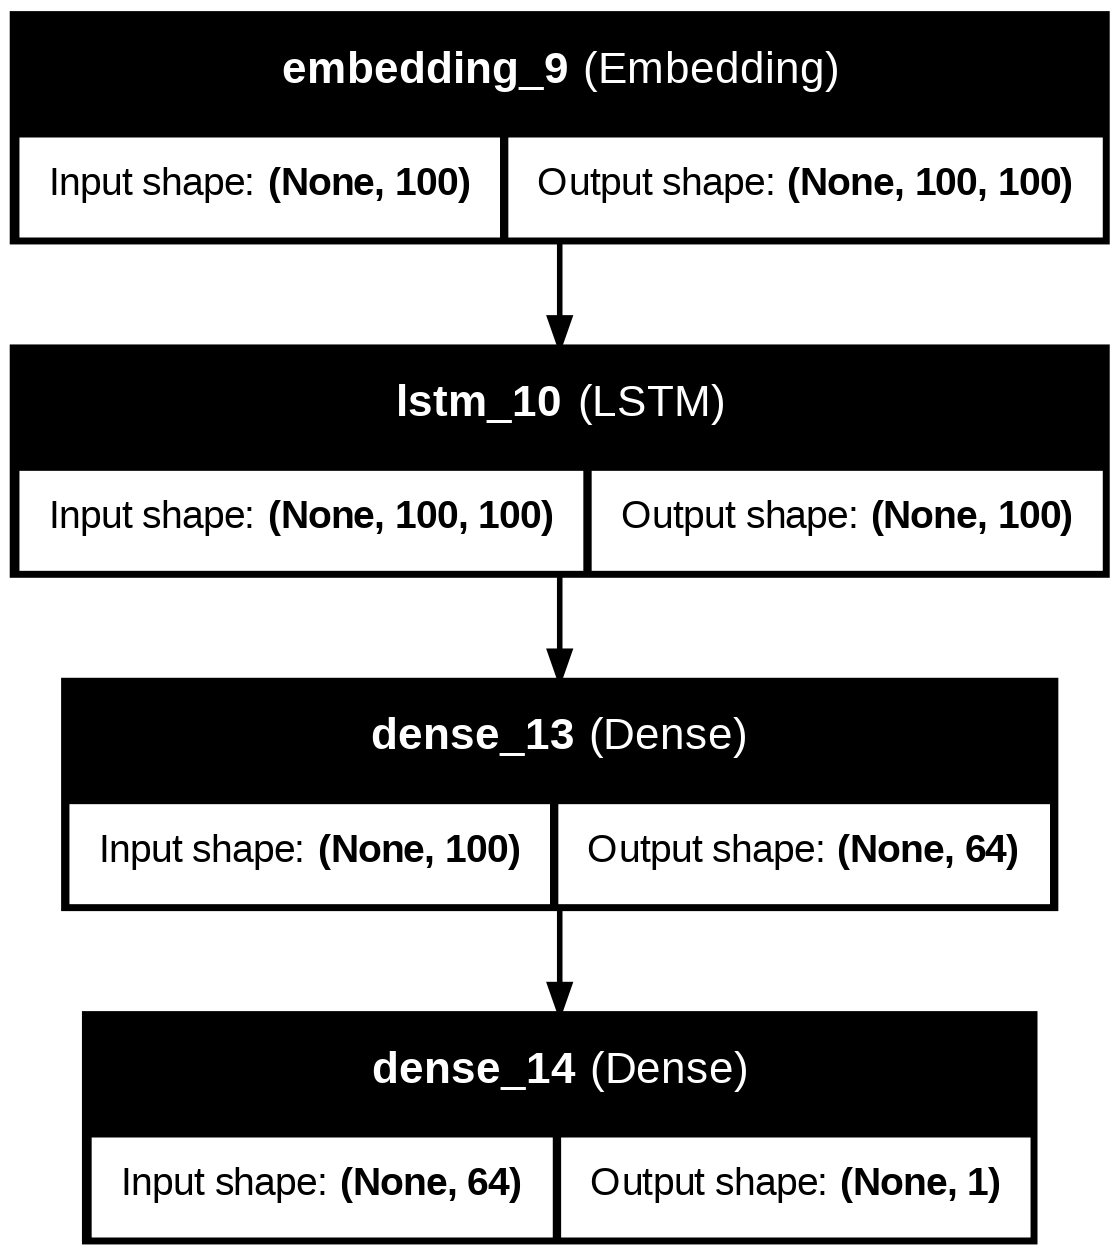

In [85]:
from tensorflow.keras.utils import plot_model
# Build the model
model.build(input_shape=(None, max_sequence_length))  # Replace max_sequence_length with the actual value
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [75]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",       
    patience=3,               
    verbose=1,
    restore_best_weights=True 
)
callbacks = [
    early_stopping_callback
]

In [86]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    # validation_split=0.1,
    # callbacks=callbacks
)

Epoch 1/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9264 - loss: 0.4082 - val_accuracy: 0.9810 - val_loss: 0.0643
Epoch 2/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9885 - loss: 0.0462 - val_accuracy: 0.9867 - val_loss: 0.0479
Epoch 3/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9934 - loss: 0.0290 - val_accuracy: 0.9884 - val_loss: 0.0459
Epoch 4/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9960 - loss: 0.0206 - val_accuracy: 0.9872 - val_loss: 0.0478
Epoch 5/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 0.9847 - val_loss: 0.0594
Epoch 6/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9976 - loss: 0.0132 - val_accuracy: 0.9862 - val_loss: 0.0538
Epoch 7/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9984 - loss: 0.0125 - val_accuracy: 0.9775 - val_loss: 0.0959
Epoch 8/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9983 - loss: 0

In [92]:
model.save('fake_news_model.h5')

## Evaluation

In [87]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0706
Test Accuracy: 98.91%


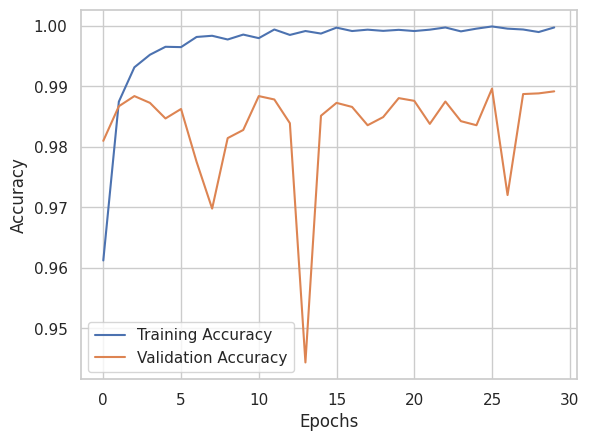

In [88]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


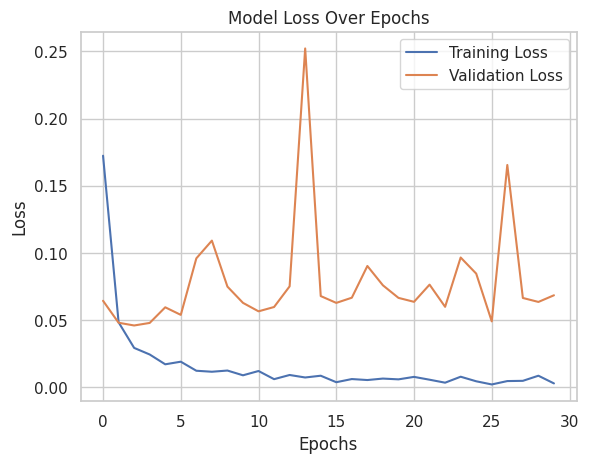

In [89]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()


In [90]:
from sklearn.metrics import confusion_matrix, classification_report
y_hat = model.predict(X_test)
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4738
           1       0.99      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



Text(66.25, 0.5, 'Real Labels')

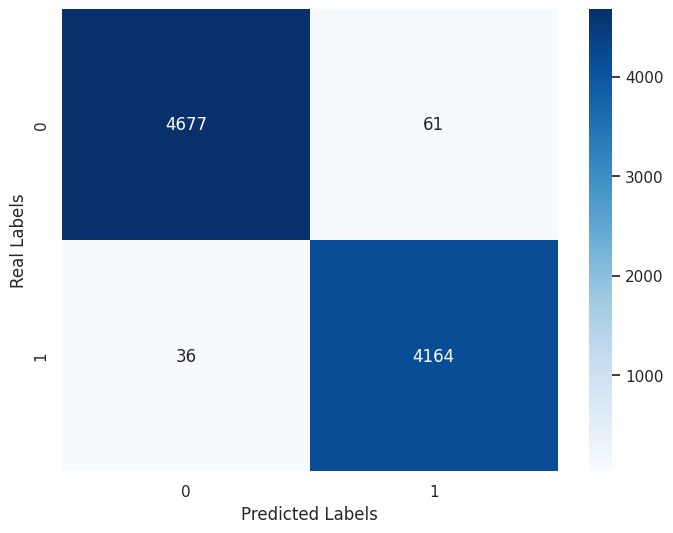

In [91]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

The performance of the LSTM-based model can be summarized as follows:

- Precision: The model achieved a precision of 0.99 for both fake news (class 0) and real news (class 1). This means that the model is highly accurate in identifying true positives, with very few false positives.

- Recall: The recall score is also 0.99 for both fake and real news, indicating that the model is effectively identifying almost all of the fake and real news instances, with very few false negatives.

- F1-Score: The F1-score for both classes is 0.99, suggesting a good balance between precision and recall. This indicates that the model is consistently performing well for both types of news.

- Accuracy: The overall accuracy of the model is 99%, which reflects the model's excellent performance in correctly classifying news articles as real or fake.

## Conclusion

The model demonstrates outstanding performance in classifying news articles with a very high accuracy of 99%. Both the precision and recall values being so close to 1 across the board show that the LSTM-based fake news detection model is highly reliable and effective in distinguishing between real and fake news. This model can be effectively used to automatically detect and filter out fake news, promoting a more informed digital ecosystem.